In [ ]:
# =============================
# FEATURE ENGINEERING SECTION
# =============================

# 1. Flag for Ischemic Heart Disease (IHD) and Peripheral Vascular Disease (PVD)
def create_comorbidity_flags(df):
    ihd_codes = ['410', '411', '412', '413', '414']
    pvd_codes = ['440', '441', '443', '444']

    def code_match(diag, codes):
        return any(str(diag).startswith(code) for code in codes)

    df['is_ihd'] = df[['diag_1', 'diag_2', 'diag_3']].apply(lambda x: any(code_match(d, ihd_codes) for d in x), axis=1).astype(int)
    df['is_pvd'] = df[['diag_1', 'diag_2', 'diag_3']].apply(lambda x: any(code_match(d, pvd_codes) for d in x), axis=1).astype(int)
    return df

df = create_comorbidity_flags(df)

# 2. Long Length of Stay
df['long_los'] = df['time_in_hospital'].apply(lambda x: 1 if x >= 4 else 0)

# 3. Polypharmacy Indicator
df['polypharmacy'] = df['num_medications'].apply(lambda x: 1 if x >= 6 else 0)

# 4. Treatment Complexity Score
df['treatment_complexity'] = df['num_procedures'] + df['num_lab_procedures'] + df['num_medications']

# 5. Interaction Terms
df['los_x_polypharmacy'] = df['long_los'] * df['polypharmacy']
df['ihd_x_pvd'] = df['is_ihd'] * df['is_pvd']

# 6. Custom Risk Score (Inspired by LIPiD Paper)
df['risk_score'] = (df['long_los'] * 1.45 +
                    df['is_ihd'] * 2.31 +
                    df['is_pvd'] * 1.58 +
                    df['num_medications'] * 1.09)

print("Feature Engineering Completed. Sample features:")
print(df[['is_ihd', 'is_pvd', 'long_los', 'polypharmacy', 'treatment_complexity', 'risk_score']].head())


Dataset Shape: (101766, 50)

Columns:
 Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

Missing Values:
 encounter_id

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:43:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.8}
Accuracy: 0.888375749238479
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     18069
           1       0.63      0.01      0.03      2285

    accuracy                           0.89     20354
   macro avg       0.76      0.51      0.48     20354
weighted avg       0.86      0.89      0.84     20354

Confusion Matrix:
 [[18050    19]
 [ 2253    32]]


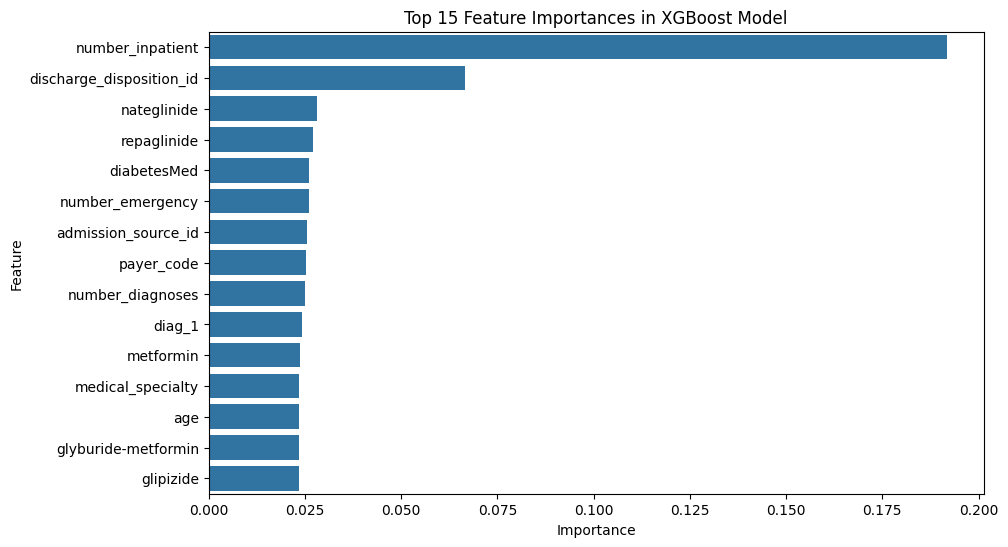

Model saved as best_xgboost_diabetes_model.pkl


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import joblib

# Load Dataset
df = pd.read_csv('/content/sample_data/diabetic_data.csv')

# Basic Exploration
print("Dataset Shape:", df.shape)
print("\nColumns:\n", df.columns)
print("\nMissing Values:\n", df.isnull().sum())
print("\nUnique values per column:\n", df.nunique())

# Clean and preprocess the dataset
df.drop(columns=['weight', 'encounter_id', 'patient_nbr'], inplace=True)
df.replace('?', np.nan, inplace=True)

# Check if after dropping NA, dataset is not empty before dropping rows
def missing_data_report(df):
    print("Missing values per column:")
    print(df.isnull().sum())

missing_data_report(df)

# Convert target variable
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# Encoding categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Splitting features and target
X = df.drop(columns=['readmitted'])
y = df['readmitted']

# Ensure X and y are not empty
if X.shape[0] == 0 or y.shape[0] == 0:
    raise ValueError("No data available for training after preprocessing. Check dataset preparation.")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Hyperparameter tuning with XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model and evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Importance
importances = best_model.feature_importances_
feature_names = df.drop(columns=['readmitted']).columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importances in XGBoost Model')
plt.show()

# Save the best model
joblib.dump(best_model, 'best_xgboost_diabetes_model.pkl')
print("Model saved as best_xgboost_diabetes_model.pkl")